<a href="https://colab.research.google.com/github/heidarimohsen92/LDNet/blob/main/Skin_cancer_LDNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  
import tensorflow.keras.backend as K
from skimage.transform import resize
from skimage.io import imread, imshow, imread_collection, concatenate_images
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Input, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization, Lambda, Add, Multiply, add

### Download and Load the [`Skin cancer: HAM10000`](https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification?select=images) dataset from kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip /content/ham1000-segmentation-and-classification.zip

# !rm -rf ham1000-segmentation-and-classification.zip

# Dataset Preprocessing

In [ ]:
# Create Lists of images and masks in Augmented paths
def label_data(fn): 
    return str(fn).replace("images", "masks").replace(".jpg", "_segmentation.png")

data_dir = '/content/images'
img_path = sorted( [os.path.join(data_dir , fn) for fn in os.listdir(data_dir) if fn.endswith('jpg')] )
mask_path = [label_data(fn) for fn in img_path]

print("number of images is : {}".format(len(img_path)))
print("number of mask is : {} \n".format(len(mask_path)))
for input_path, target_path in zip(img_path[:10], mask_path[:10]):
    print(input_path, "|", target_path)

number of images is : 10015
number of mask is : 10015 

/content/images/ISIC_0024306.jpg | /content/masks/ISIC_0024306_segmentation.png
/content/images/ISIC_0024307.jpg | /content/masks/ISIC_0024307_segmentation.png
/content/images/ISIC_0024308.jpg | /content/masks/ISIC_0024308_segmentation.png
/content/images/ISIC_0024309.jpg | /content/masks/ISIC_0024309_segmentation.png
/content/images/ISIC_0024310.jpg | /content/masks/ISIC_0024310_segmentation.png
/content/images/ISIC_0024311.jpg | /content/masks/ISIC_0024311_segmentation.png
/content/images/ISIC_0024312.jpg | /content/masks/ISIC_0024312_segmentation.png
/content/images/ISIC_0024313.jpg | /content/masks/ISIC_0024313_segmentation.png
/content/images/ISIC_0024314.jpg | /content/masks/ISIC_0024314_segmentation.png
/content/images/ISIC_0024315.jpg | /content/masks/ISIC_0024315_segmentation.png


## Split Data

In [ ]:
# Splitting the data into train, validation and test sets
X_train, X_val, Y_train, Y_val = train_test_split(img_path, mask_path, test_size = 0.20, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.20, random_state=42)

print("number of train is : {}".format(len(X_train)))
print("number of val is : {} ".format(len(X_val)))
print("number of test is : {} ".format(len(X_test)))

number of train is : 8012
number of val is : 1602 
number of test is : 401 


## Custom Data Generators

In [ ]:
# This function will load and resize images and return arrays to the generators
def preprocess(image_path, mask_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256), method='nearest')
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [ ]:
def tf_dataset(x, y, batch=16):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

### **DropBlock2D LDNet**

In [ ]:
# DropBlock: A regularization method for convolutional networks
# arXiv. https://arxiv.org/abs/1810.12890

def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))


class DropBlock2D(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, scale=True,name=None, **kwargs):
        super(DropBlock2D, self).__init__(name="DropBlock2D")
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.names = name
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale
        super(DropBlock2D, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update( {"block_size": self.block_size,"keep_prob": self.keep_prob,"name": self.names })
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 4
        _, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask
        p1 = (self.block_size - 1) // 2
        p0 = (self.block_size - 1) - p1
        self.padding = [[0, 0], [p0, p1], [p0, p1], [0, 0]]
        self.set_keep_prob()
        super(DropBlock2D, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(self.scale,
                             true_fn=lambda: output *tf.cast(tf.size(mask), dtype=tf.float32)  / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        w, h = tf.cast(self.w, dtype=tf.float32), tf.cast(self.h, dtype=tf.float32)
        
        self.gamma = (1. - self.keep_prob) * (w * h) / (self.block_size ** 2) / \
                     ((w - self.block_size + 1) * (h - self.block_size + 1))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                       self.h - self.block_size + 1,
                                       self.w - self.block_size + 1,
                                       self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool(mask, [1, self.block_size, self.block_size, 1], [1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask

### **Attention_Block LDNet**

In [ ]:
def Attention_Block(x, g, inter_shape, name="Attention_Block"):
    #Gated attention block used in skip connections in the U-Net
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=1,
                   strides=1,
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=(shape_x[1] // shape_g[1],
                              shape_x[2] // shape_g[2]),
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],
                                             shape_x[2] //
                                             shape_sigmoid[2]))(psi)


    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=inter_shape,
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization(name=name)(output)
    return output

### **Up_Block LDNet**

In [ ]:
# Up_Block
def Up_Block(input_layer, filters=128, kernel_size=3, name="Up_Block"):
    x = UpSampling2D((2,2))(input_layer) 
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    output = Activation("relu", name=name)(x)
    return output 

# Building our LDNet Model

In [ ]:
n_label = 1

inputs = Input(shape=(256,256,3), name = "Main_Input")
''' ENCODER ''' 
# Conv-1 block
down_conv_1 = Conv2D(32, kernel_size=(3,3), padding="same")(inputs)
down_conv_1 = BatchNormalization()(down_conv_1)
down_conv_1 = Conv2D(32, kernel_size=(3,3), padding='same')(down_conv_1)
down_conv_1 = BatchNormalization()(down_conv_1)
down_conv_1 = Activation("relu", name="down_conv_1")(down_conv_1)
down_conv_1 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_1)
down_conv_1 = MaxPool2D(pool_size=(2,2), strides=(2,2))(down_conv_1)
# Conv-2 block
down_conv_2 = Conv2D(64, kernel_size=(3,3), padding="same")(down_conv_1)
down_conv_2 = BatchNormalization()(down_conv_2)
down_conv_2 = Conv2D(64, kernel_size=(3,3), padding='same')(down_conv_2)
down_conv_2 = BatchNormalization()(down_conv_2)
down_conv_2 = Activation("relu", name="down_conv_2")(down_conv_2)
down_conv_2 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_2)
down_conv_2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(down_conv_2)
# Conv-3 block
down_conv_3 = Conv2D(128, kernel_size=(3,3), padding="same")(down_conv_2)
down_conv_3 = BatchNormalization()(down_conv_3)
down_conv_3 = Conv2D(128, kernel_size=(3,3), padding='same')(down_conv_3)
down_conv_3 = BatchNormalization()(down_conv_3)
down_conv_3 = Activation("relu", name="down_conv_3")(down_conv_3)
down_conv_3 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_3)
down_conv_3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(down_conv_3)
# Conv-4 block
down_conv_4 = Conv2D(256, kernel_size=(3,3), padding="same")(down_conv_3)
down_conv_4 = BatchNormalization()(down_conv_4)
down_conv_4 = Conv2D(256, kernel_size=(3,3), padding='same')(down_conv_4)
down_conv_4 = BatchNormalization()(down_conv_4)
down_conv_4 = Activation("relu", name="down_conv_4")(down_conv_4)
down_conv_4 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_4)

''' Astrous spatial Pooling block '''
box1 = Conv2D(256, kernel_size=(1,1), dilation_rate=1, padding="same", activation='relu')(down_conv_4)
box2 = Conv2D(256, kernel_size=(3,3), dilation_rate=2, padding="same", activation='relu')(down_conv_4)
box3 = Conv2D(256, kernel_size=(3,3), dilation_rate=4, padding="same", activation='relu')(down_conv_4)
box4 = Conv2D(256, kernel_size=(3,3), dilation_rate=8, padding="same", activation='relu')(down_conv_4)
box5 = Conv2D(256, kernel_size=(3,3), dilation_rate=16, padding="same", activation='relu')(down_conv_4)
box6 = Conv2D(256, kernel_size=(3,3), dilation_rate=32, padding="same", activation='relu')(down_conv_4)
concatted = Concatenate()([box1, box2, box3, box4, box5, box6])
ASPP = Conv2D(256, kernel_size=(1,1), padding='same', name="ASPP")(concatted)

''' Decoder '''
# up_block & attention_block
up_block_4 = Up_Block(ASPP, filters=128, kernel_size=3, name="up_block_4")
attention_4 = Attention_Block(up_block_4, down_conv_3, 256, name="attention_4")
# Conv-3 block
up_conv_3 = Conv2D(128, kernel_size=(3,3), padding="same")(attention_4)
up_conv_3 = BatchNormalization()(up_conv_3)
up_conv_3 = Conv2D(128, kernel_size=(3,3), padding='same')(up_conv_3)
up_conv_3 = BatchNormalization()(up_conv_3)
up_conv_3 = Activation("relu", name="up_conv_3")(up_conv_3)
# up_block & attention_block
up_block_3 = Up_Block(up_conv_3, filters=64, kernel_size=3, name="up_block_3")
attention_3 = Attention_Block(up_block_3, down_conv_2, 128, name="attention_3")
# Conv-2 block
up_conv_2 = Conv2D(64, kernel_size=(3,3), padding="same")(attention_3)
up_conv_2 = BatchNormalization()(up_conv_2)
up_conv_2 = Conv2D(64, kernel_size=(3,3), padding='same')(up_conv_2)
up_conv_2 = BatchNormalization()(up_conv_2)
up_conv_2 = Activation("relu", name="up_conv_2")(up_conv_2)
# up_block & attention_block
up_block_2 = Up_Block(up_conv_2, filters=32, kernel_size=3, name="up_block_2")
attention_2 = Attention_Block(up_block_2, down_conv_1, 64, name="attention_2")
# Conv-1 block
up_conv_1 = Conv2D(32, kernel_size=(3,3), padding="same")(attention_2)
up_conv_1 = BatchNormalization()(up_conv_1)
up_conv_1 = Conv2D(32, kernel_size=(3,3), padding='same')(up_conv_1)
up_conv_1 = BatchNormalization()(up_conv_1)
up_conv_1 = Activation("relu", name="up_conv_1")(up_conv_1)
# Output
outputs = Conv2D(n_label, kernel_size=(1,1), activation='sigmoid')(up_conv_1)

tf.keras.backend.clear_session()
model = Model(inputs=inputs, outputs=outputs, name="LDNet")
model.summary()

Model: "LDNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Main_Input (InputLayer)        [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['Main_Input[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Metric

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)  

### Compile The Model


In [ ]:
# Compile The Model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=[dice_coef])

# Initialize our callbacks
checkpoint_filepath = "save_model/best-weights"
checkpoint = ModelCheckpoint(checkpoint_filepath,
                             monitor="val_loss",
                             mode="min",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights=True)

# **Fit our model**

In [ ]:
batch_size = 16
train_dataset = tf_dataset(X_train, Y_train, batch=batch_size)
val_dataset = tf_dataset(X_val, Y_val, batch=batch_size)
test_dataset = tf_dataset(X_test, Y_test, batch=batch_size)

In [ ]:
# Train the Model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=30, verbose=1, 
                    callbacks=[checkpoint, earlystop])

Epoch 1/30
501/501 [==============================] - ETA: 0s - loss: 0.2346 - dice_coef: 0.7411
Epoch 1: val_loss improved from inf to 0.22353, saving model to save_model/best-weights
501/501 [==============================] - 392s 722ms/step - loss: 0.2346 - dice_coef: 0.7411 - val_loss: 0.2235 - val_dice_coef: 0.7733
Epoch 2/30
501/501 [==============================] - ETA: 0s - loss: 0.1630 - dice_coef: 0.8202
Epoch 2: val_loss improved from 0.22353 to 0.19952, saving model to save_model/best-weights
501/501 [==============================] - 350s 698ms/step - loss: 0.1630 - dice_coef: 0.8202 - val_loss: 0.1995 - val_dice_coef: 0.8215
Epoch 3/30
501/501 [==============================] - ETA: 0s - loss: 0.1453 - dice_coef: 0.8393
Epoch 3: val_loss did not improve from 0.19952
501/501 [==============================] - 352s 703ms/step - loss: 0.1453 - dice_coef: 0.8393 - val_loss: 0.2268 - val_dice_coef: 0.8281
Epoch 4/30
501/501 [==============================] - ETA: 0s - loss: 0

## evaluate model

In [ ]:
checkpoint_filepath = "save_model/best-weights"
model.load_weights(checkpoint_filepath)

train_loss, train_accuracy = model.evaluate(train_dataset)
validation_loss, validation_accuracy = model.evaluate(val_dataset)
test_loss, test_accuracy = model.evaluate(test_dataset)
# model.evaluate(X_test, Y_test, batch_size=16)

26/26 [==============================] - 6s 225ms/step - loss: 0.1403 - dice_coef: 0.8673


## Visualize the Results

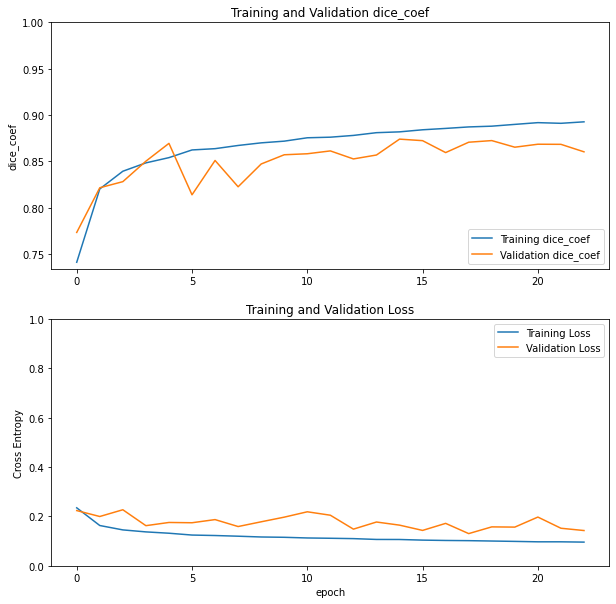

In [ ]:
dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(dice_coef, label='Training dice_coef')
plt.plot(val_dice_coef, label='Validation dice_coef')
plt.legend(loc='lower right')
plt.ylabel('dice_coef')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation dice_coef')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Showing our predicted masks on our test data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


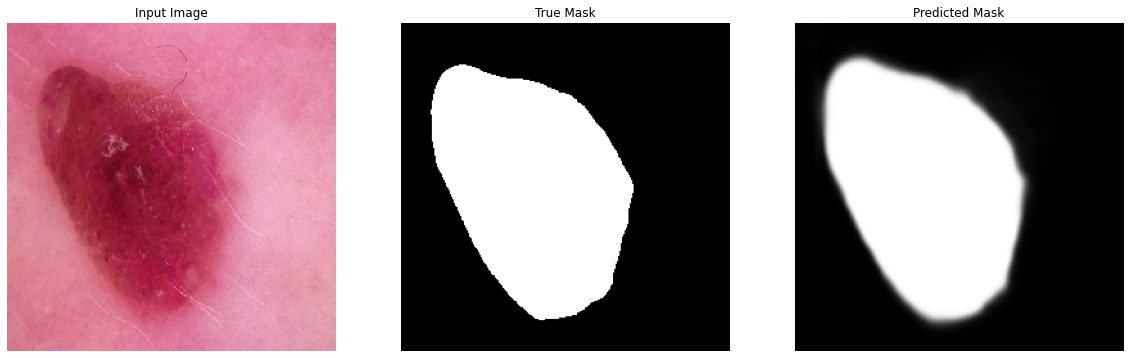

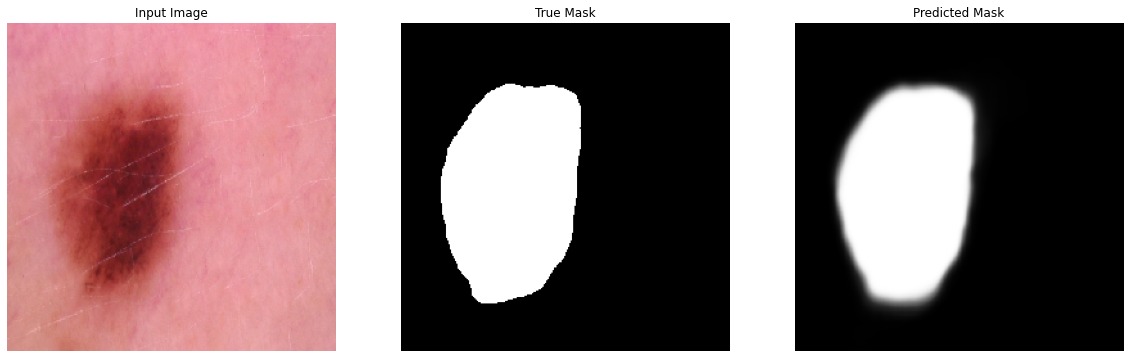

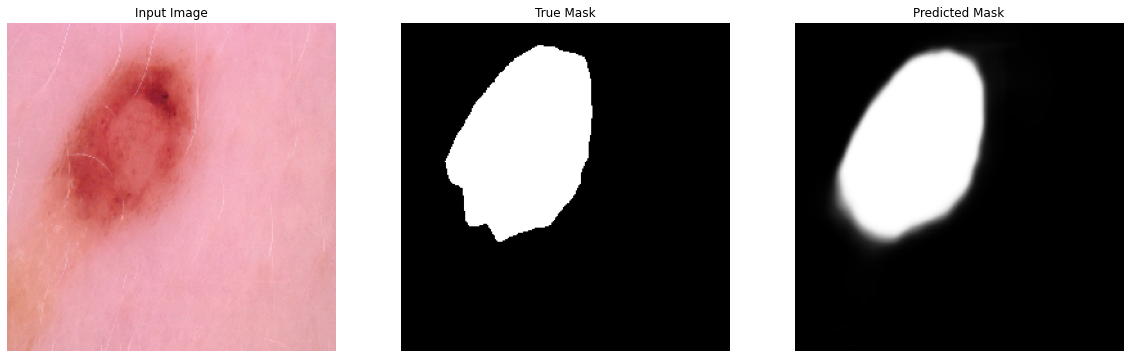

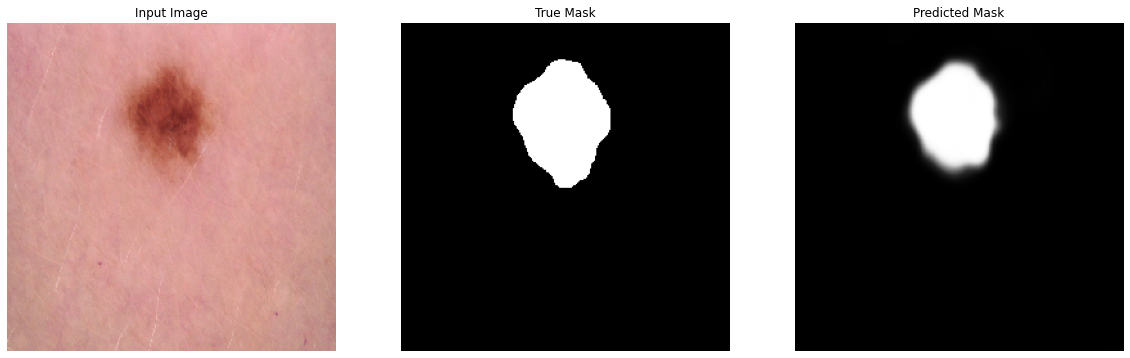

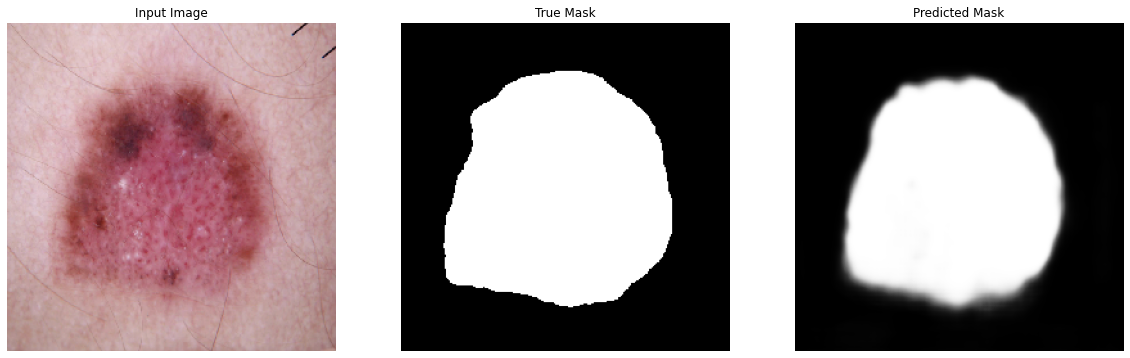

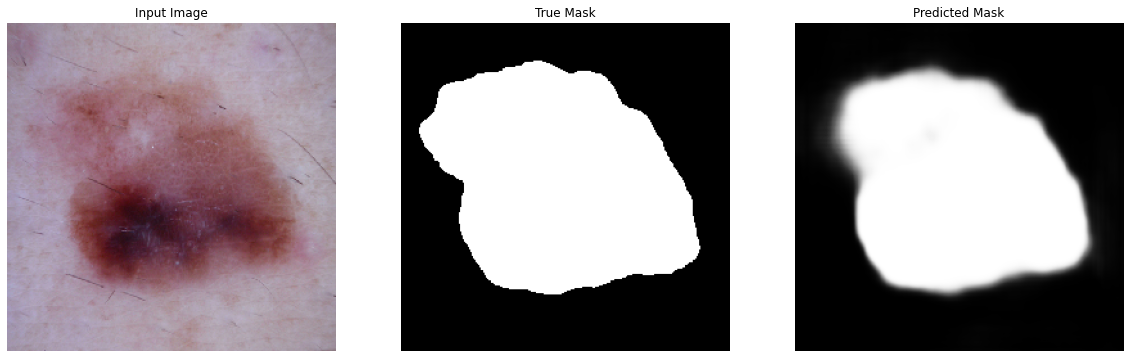

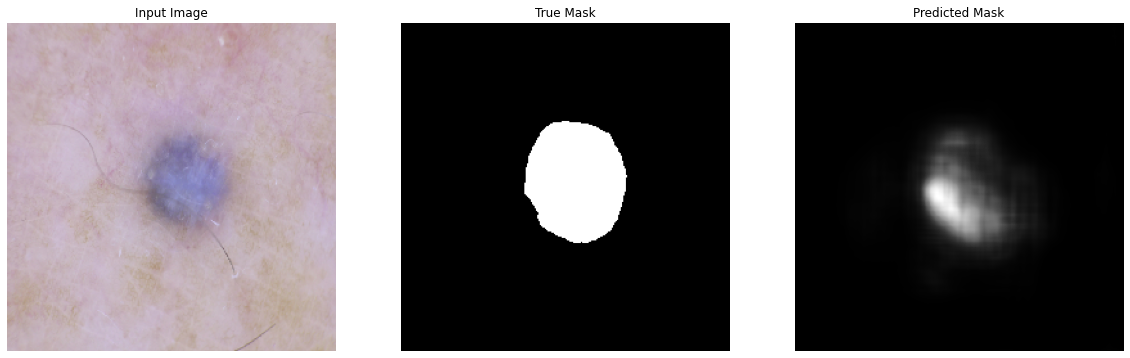

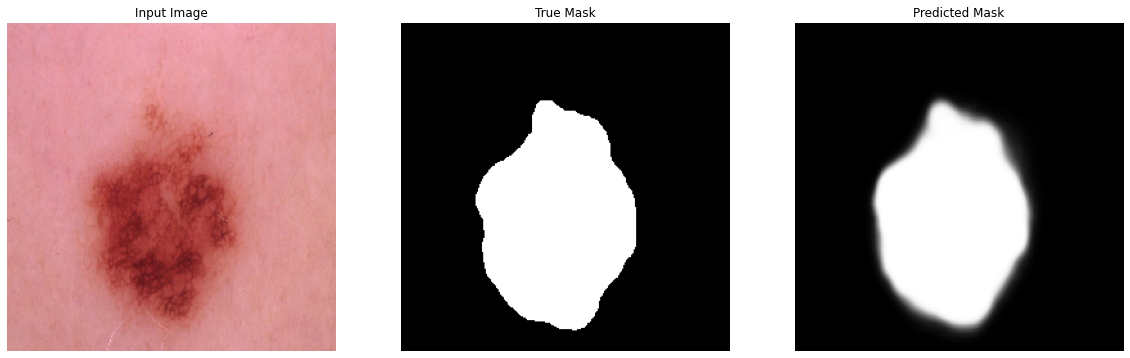

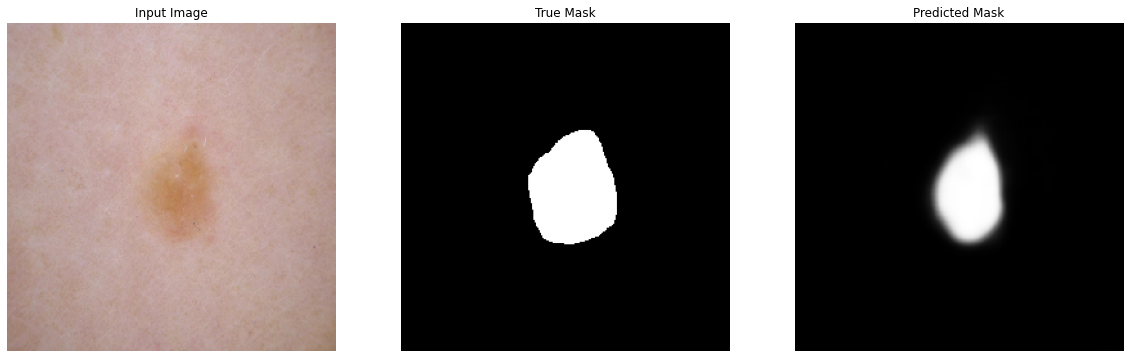

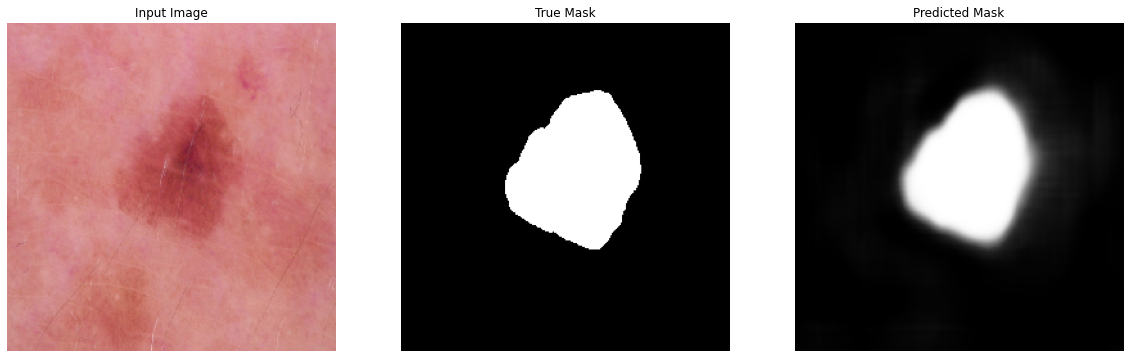

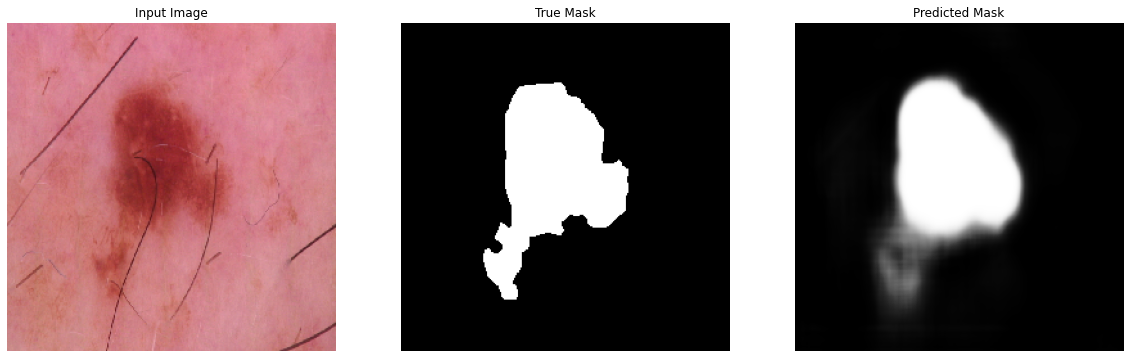

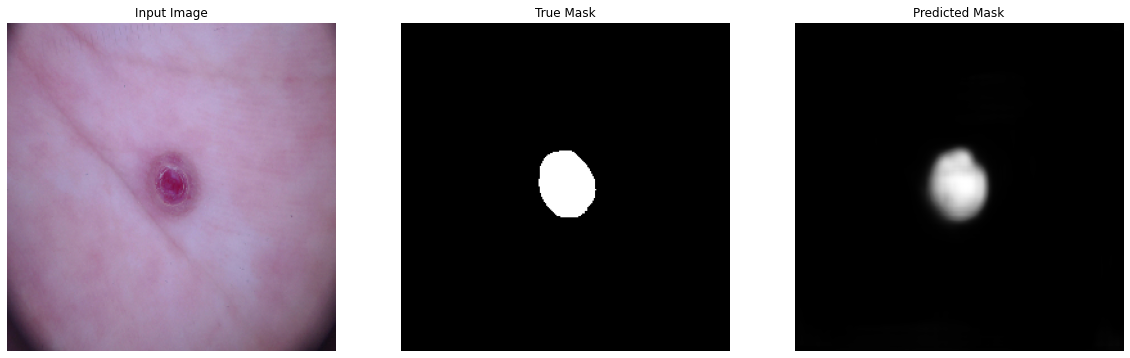

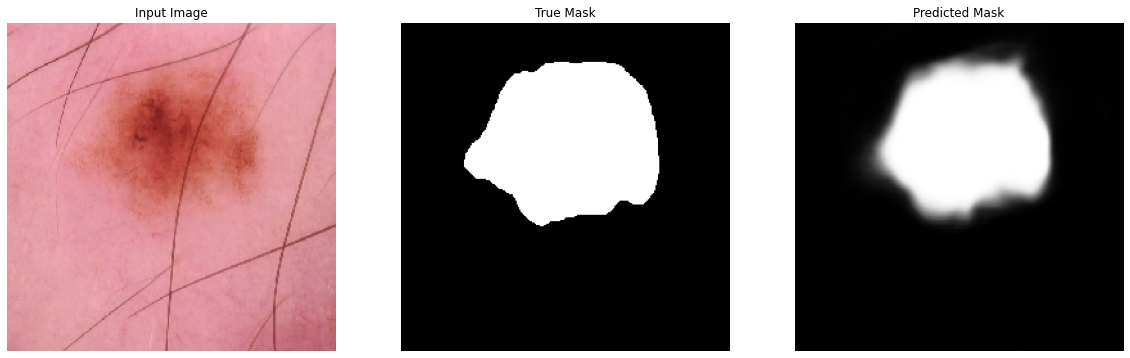

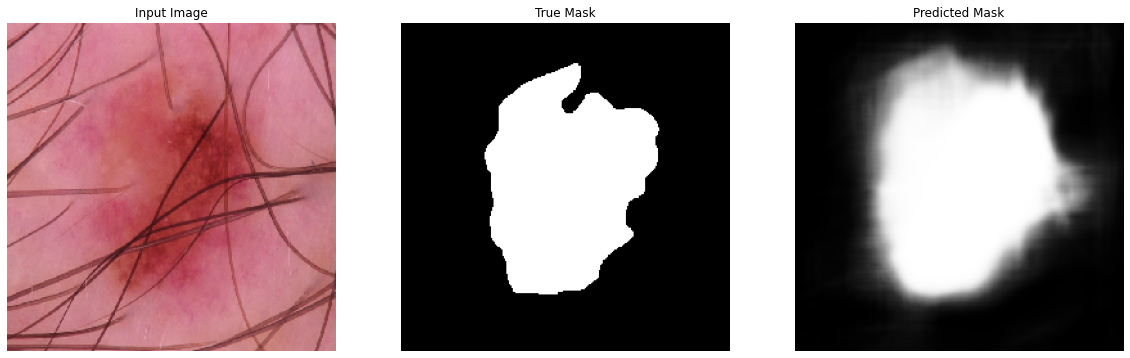

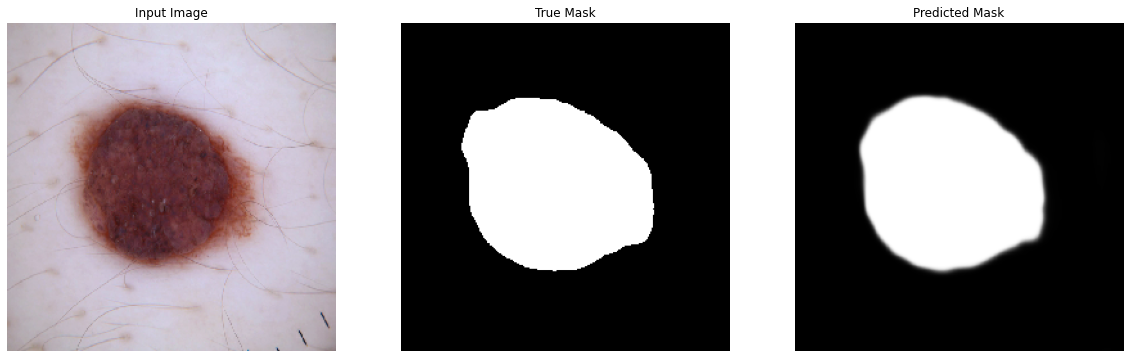

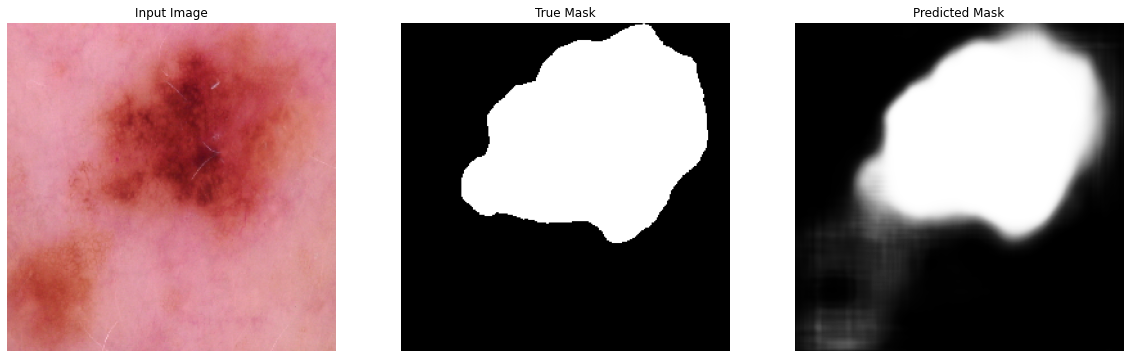

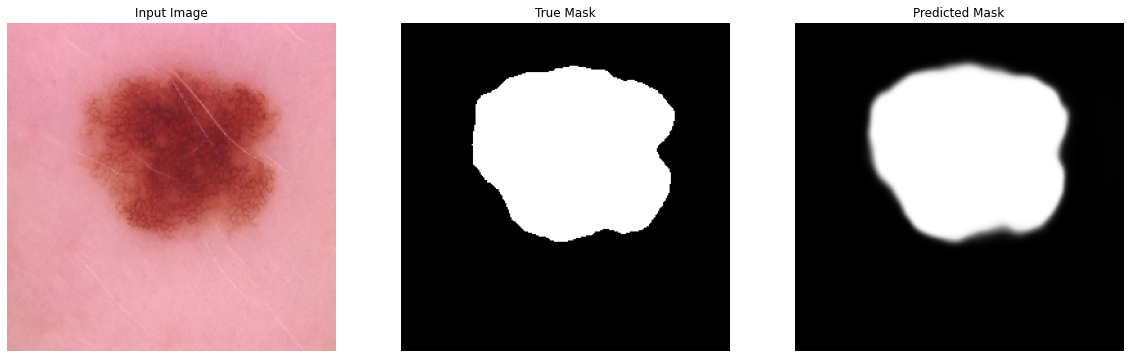

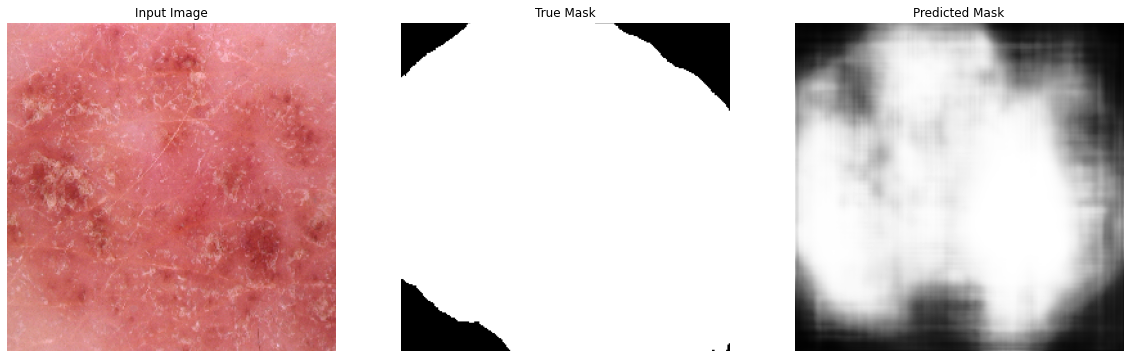

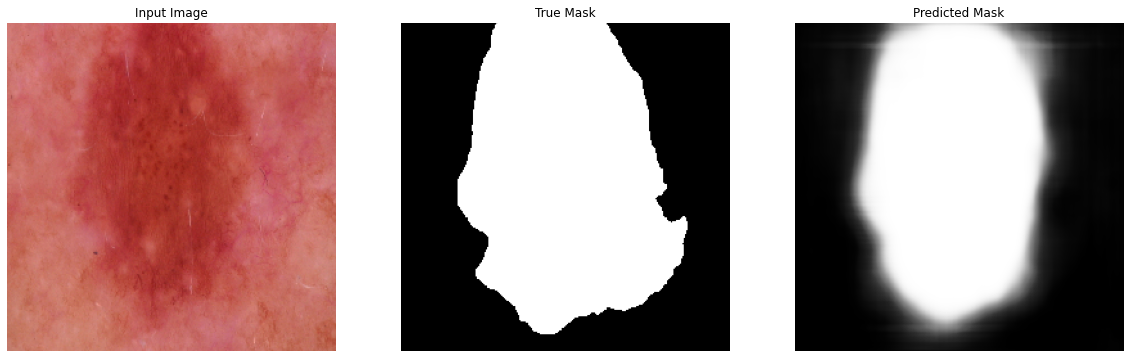

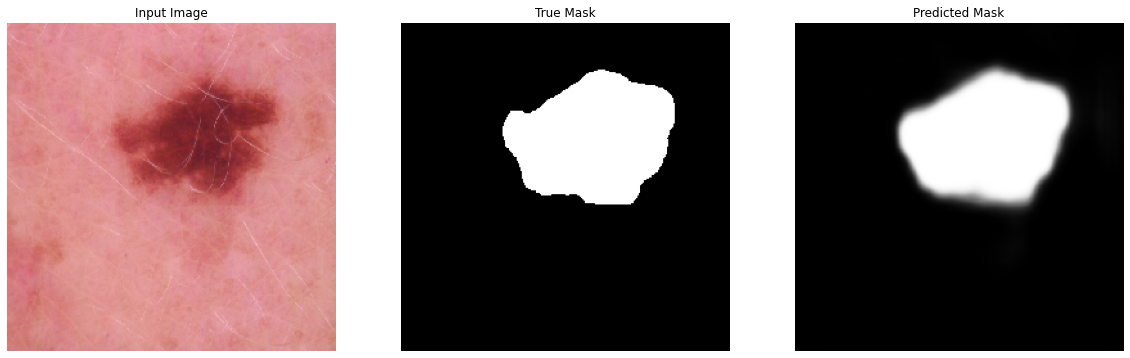

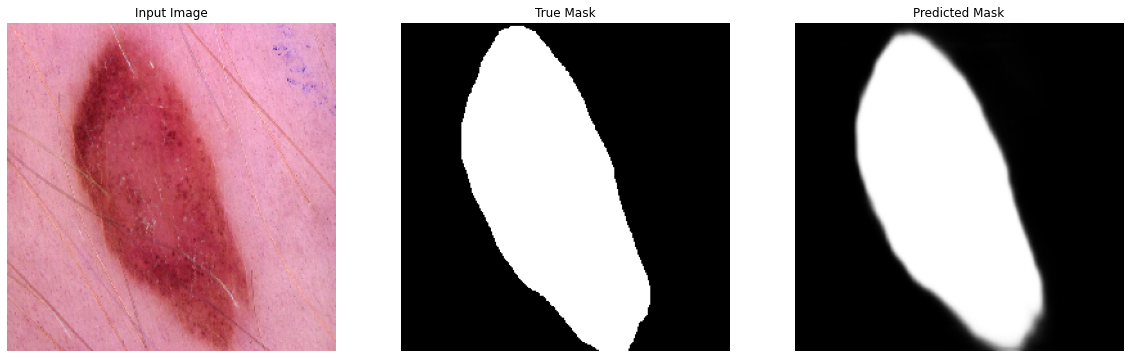

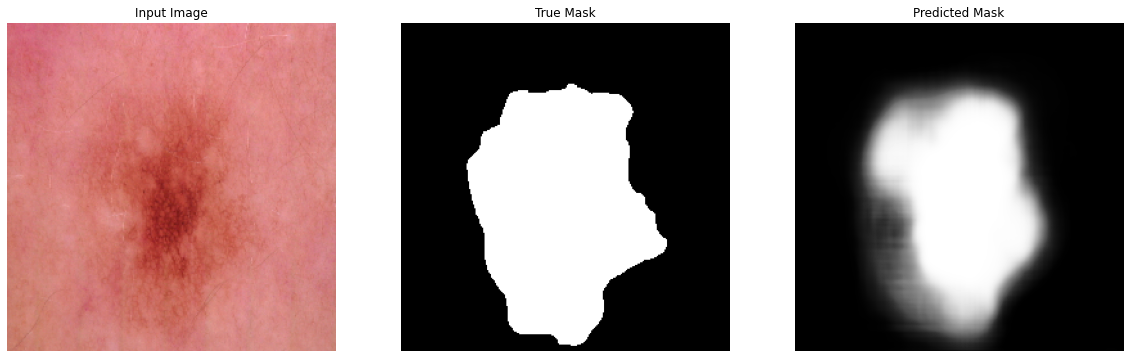

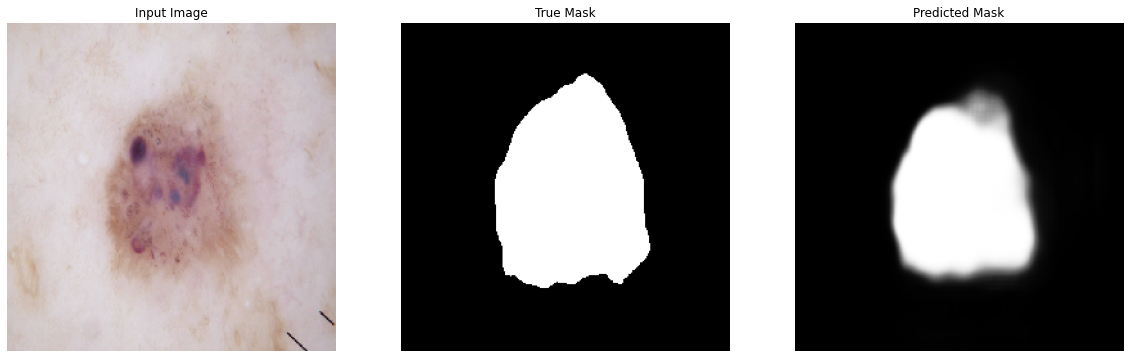

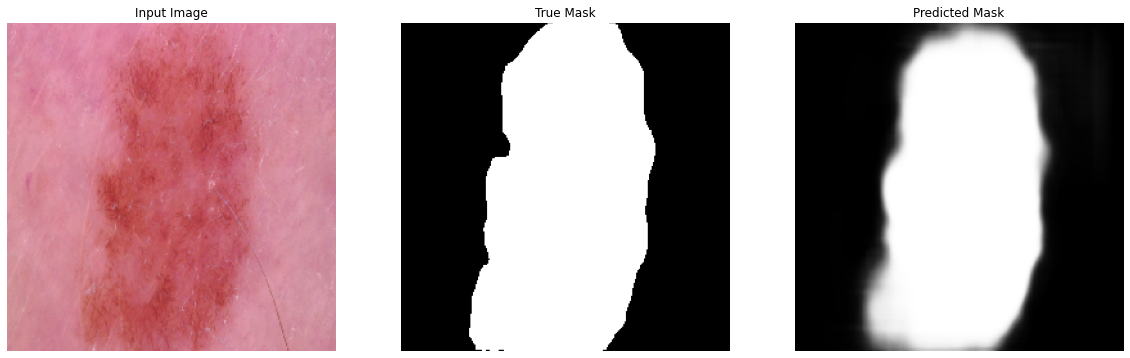

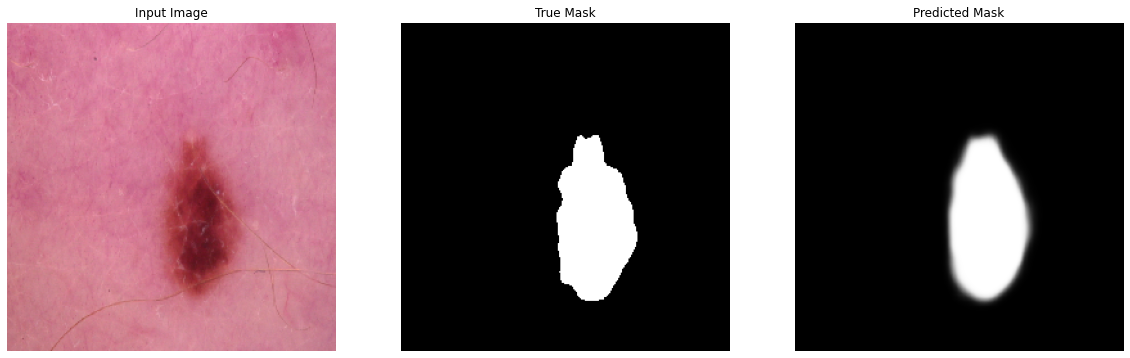

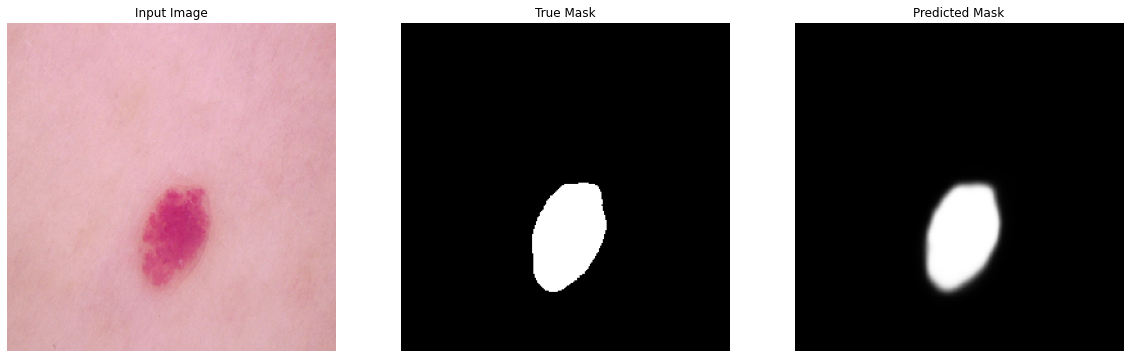

In [ ]:
for image, mask in test_dataset.take(30):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    # Our original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0])
    plt.title('Input Image')
    plt.axis('off')
    # Our original Mask
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(mask[0]), cmap="gray")
    plt.title('True Mask')
    plt.axis('off')
    # Our Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_mask[0]), cmap="gray")
    plt.title('Predicted Mask')
    plt.axis('off')